In [217]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import functions as f
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [218]:
# better visualization of numbers
pd.options.display.float_format = '{:,.2f}'.format 

# Diary

- I tried different methods to fill missing values such as linear regression and knnImputer. Because the initial idea was comparing different model accuracy then select the best one. But as i have a lot of categorical data which is difficult and no sense to transform into numerical values I discarded these ideas. Then i filled missing values using random forest reressor. 

- Calculated prticipation of women and men to olympic games and their  success. -> it is not a good idea to compare two genders, bc they don't compate in the same area, there are women games  and men games. 

- I tried to show how are the distribution of gender over year too participate to olypic games, plotted 10 team and 10 athlete with most medals. 




# Comments

As I notice that looking in a  certain timeline i see that there  are not complete information i tried to print for golf games before 1900, and we can see that there are not information about who was in second place or third. In the dataset there are collected only few information for each sport/year/athlete/etc..

## IDEAS

TO DO for dataset exploration: 
1. compare male and female athlets participation to the games each year
2. correlation between age, sex, height and weight.
3. distribution of medals per age and per sex
4. Check if medals are distribuited correctly, in sense of: if there are years that have more medal than the maximum they can have. For this study the olympics description on kaggle. 
5. LOOK IF IT MAKES SENSE TO ASSOCIATE AN ID TO EACH COUNTRY IN *noc_region.csv* DATASET AND USE IT FOR ANALYSING THE SUCCESS OF THEM?
6. Should I transform float data in int? not all of them, like medals etc ?

# DATA EXPLORATION AND DATA WRANGLING

In [219]:
olympic_df = pd.read_csv('dataset_olympic_data/dataset_olympics.csv')
noc_region_df = pd.read_csv('dataset_olympic_data/noc_region.csv')

## EXPLORING THE DATASET

In [220]:
noc_region_df

In [221]:
noc_region_df['notes'].unique()


In [222]:
noc_region_df[noc_region_df['notes'] == 'Newfoundland']

In [223]:
olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.00,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.00,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.00,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [224]:
chn_team = olympic_df[olympic_df['NOC']=='CHN']

In [225]:
chn_team['Team'].unique()

array(['China', 'China-2', 'China-1'], dtype=object)

In [226]:
len(noc_region_df['reg'])

230

In [227]:
olympic_df.tail()

In [228]:
olympic_df.info()

In [229]:
olympic_df.describe()

In [230]:
olympic_df.isna().sum()

In [231]:
olympic_df['Medal'].unique()

In [232]:
olympic_df.nunique()

ID        35658
Name      35556
Sex           2
Age          68
Height       87
Weight      173
Team        827
NOC         226
Games        51
Year         35
Season        2
City         42
Sport        65
Event       744
Medal         3
dtype: int64

In [233]:
medal_mask = ['Gold', 'Silver', 'Bronze']
olympic_df['Medal'].value_counts()[medal_mask] 

Medal
Gold      3292
Silver    3190
Bronze    3208
Name: count, dtype: int64

### Histogram

From the histogram below we can see that:

- The majority of the athletes age is between ~18 and ~25
- Most athletes are between 160cm and 190cm 
- Most athletes weigh between 50 and 100 and the peak is  around 175
- Participation to the olympic games has increased over time. 

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'Year'}>]], dtype=object)

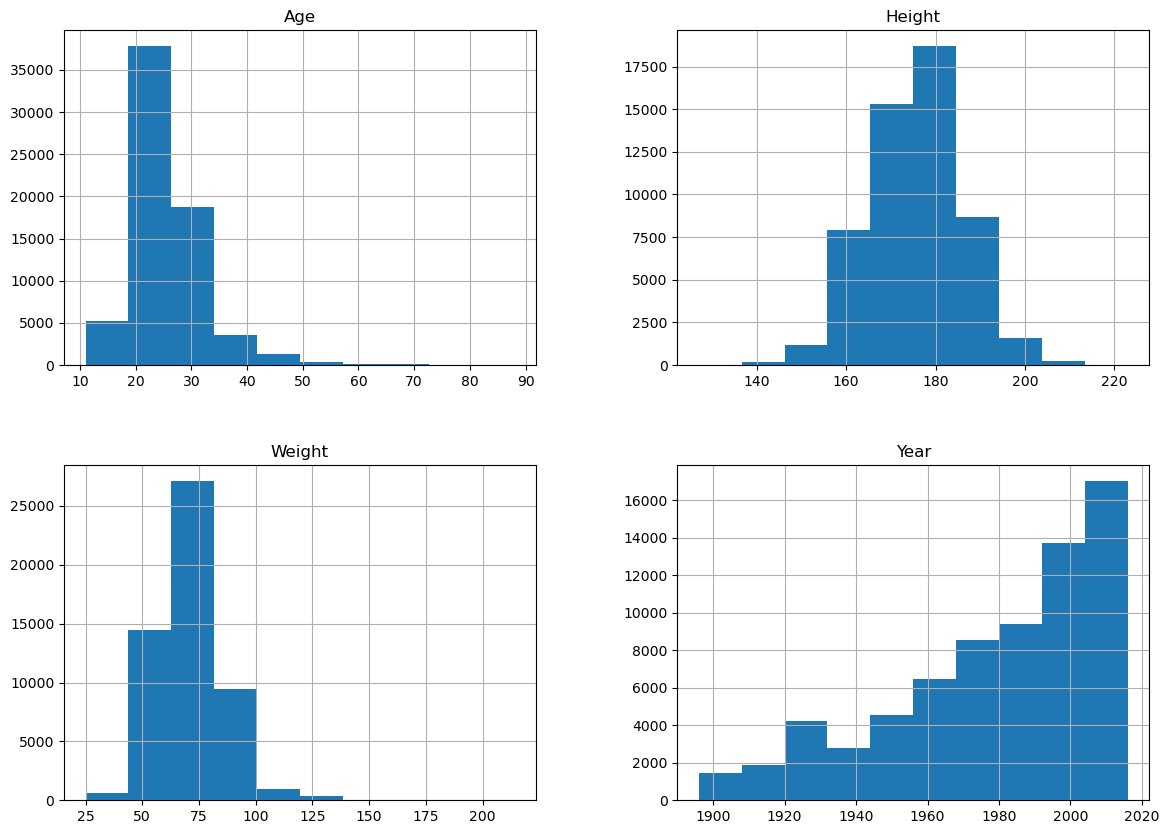

In [234]:
olympic_df.drop(columns='ID').hist(figsize=(14,10))

## DATA CLEANING, HANDLING MISSING VALUES

In [235]:
olympic_df.isnull().sum()

ID            0
Name          0
Sex           0
Age        2732
Height    16254
Weight    17101
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal     60310
dtype: int64

### Merge NOC dataset with Olympic dataset


#### Clean NOC dataset

In [260]:
noc_region_df[noc_region_df['reg'].isnull()]

,NOC,reg,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [240]:
noc_region_df.rename(columns={'noc_region' : 'NOC'}, inplace=True)

In [241]:
olympic_df = olympic_df.merge(noc_region_df, on='NOC')

In [242]:
olympic_df['notes'].unique()

array([nan, 'United Arab Republic', 'North Yemen', 'Virgin Islands',
       'Turks and Caicos Islands', 'Trinidad and Tobago',
       'Netherlands Antilles', 'South Yemen', 'Australasia',
       'Serbia and Montenegro', 'Individual Olympic Athletes',
       'Yugoslavia', 'Refugee Olympic Team', 'Crete',
       'Antigua and Barbuda', 'Hong Kong', 'Bohemia',
       'West Indies Federation', 'North Borneo', 'Unknown', 'Tuvalu'],
      dtype=object)

Drop notes column as we won't use it and we can not fill the missing ones. 

In [243]:
olympic_df = olympic_df.drop(columns=['notes'])

In [244]:
olympic_df

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,reg
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China
2,3,Gunnar Nielsen Aaby,M,24.00,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark
3,4,Edgar Lindenau Aabye,M,34.00,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.00,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69557,35656,Stuart Fitzsimmons,M,19.00,NaN,NaN,Great Britain,GBR,1976 Winter,1976,Winter,Innsbruck,Alpine Skiing,Alpine Skiing Men's Giant Slalom,NaN,UK
69558,35656,Stuart Fitzsimmons,M,19.00,NaN,NaN,Great Britain,GBR,1976 Winter,1976,Winter,Innsbruck,Alpine Skiing,Alpine Skiing Men's Slalom,NaN,UK
69559,35657,"David Thomas ""Dave"" Fitzsimons",M,26.00,170.00,65.00,Australia,AUS,1976 Summer,1976,Summer,Montreal,Athletics,"Athletics Men's 10,000 metres",NaN,Australia
69560,35657,"David Thomas ""Dave"" Fitzsimons",M,30.00,170.00,65.00,Australia,AUS,1980 Summer,1980,Summer,Moskva,Athletics,"Athletics Men's 5,000 metres",NaN,Australia


### Check and clean duplicates:

In [ ]:
print('There are {} duplicate rows in olympic_df based on all columns.'.format(olympic_df.duplicated().sum()))

In [ ]:
olympic_df.drop_duplicates(keep='first', inplace=True)

In [ ]:
print('There are {} duplicate rows in olympic_df based on all columns.'.format(olympic_df.duplicated().sum()))

### Missing Values

Percentage of missing data:

In [245]:
# missing_percentage = ((olympic_df.isnull().sum())/len(olympic_df))*100
# missing_data = pd.DataFrame({'Missing Values': olympic_df.isnull().sum(), 'Percentage': missing_percentage})
# print(missing_data)

**Medal column cleaning**

Filling missing values in Medal column with fillna(), because actually they are not missing values where we have NaN, but it indicates that the athlet didn't get any medal

In [246]:
olympic_df['Medal'] = olympic_df['Medal'].fillna(value='no-medal')

In [247]:
olympic_df.isnull().sum()

ID            0
Name          0
Sex           0
Age        2669
Height    15861
Weight    16704
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
reg           8
dtype: int64

In [254]:
noc_region_df

,NOC,reg,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
...,...,...,...
225,YEM,Yemen,NaN
226,YMD,Yemen,South Yemen
227,YUG,Serbia,Yugoslavia
228,ZAM,Zambia,NaN


In [258]:
noc_region_df[noc_region_df['NOC']=='ROT']

,NOC,reg,notes


In [265]:
olympic_df.isnull().sum()

ID            0
Name          0
Sex           0
Age        2669
Height    15861
Weight    16704
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
reg           8
dtype: int64

In [267]:
olympic_df[olympic_df['reg'].isnull()]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,reg
6256,3515,Paulo Amotun Lokoro,M,24.00,170.00,61.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,"Athletics Men's 1,500 metres",no-medal,NaN
7884,4379,Rami Anis,M,25.00,178.00,78.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Freestyle,no-medal,NaN
7885,4379,Rami Anis,M,25.00,178.00,78.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Butterfly,no-medal,NaN
21423,11364,Yiech Pur Biel,M,21.00,178.00,62.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Men's 800 metres,no-medal,NaN
31530,16287,Mabika Yolande Bukasa,F,28.00,170.00,70.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Judo,Judo Women's Middleweight,no-medal,NaN
40007,20693,James Nyang Chiengjiek,M,24.00,179.00,59.00,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Men's 400 metres,no-medal,NaN
60685,31292,Fritz Eccard,M,NaN,NaN,NaN,Unknown,UNK,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Architecture,no-medal,NaN
64269,33094,Logona Esau,M,21.00,163.00,69.00,Tuvalu,TUV,2008 Summer,2008,Summer,Beijing,Weightlifting,Weightlifting Men's Lightweight,no-medal,NaN


Drop rows with nan values in region bc we  don't know which country are they. 

In [270]:
olympic_df.dropna(subset=['reg'], inplace=True)

In [271]:
olympic_df[olympic_df['reg'].isnull()]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,reg


**Filling  missing values with random forest**

In [272]:
for column in olympic_df.columns:
    if olympic_df[column].isna().any():
        olympic_df = f.impute_missing_values_with_random_forest(olympic_df, column)

In [ ]:
olympic_df.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

## PLOTS

### PARTICIPATION OF MALE AND FEMALE  ATHLETES  IN THE OLYMPIC GAMES OVER THE YEARS 

It is evident that women's involvement was minimal before the 1970s, with a significant increase starting in the 1980s. The data shows that while male athletes consistently had higher participation rates, the gap between male and female athletes has been narrowing steadily in recent decades.

The second graph shows the number of medals won by male and female athletes over the years. It is evident that men consistently won more medals than women until around the 1960s. From this point onwards, the gap between the number of medals won by men and women began to decrease.

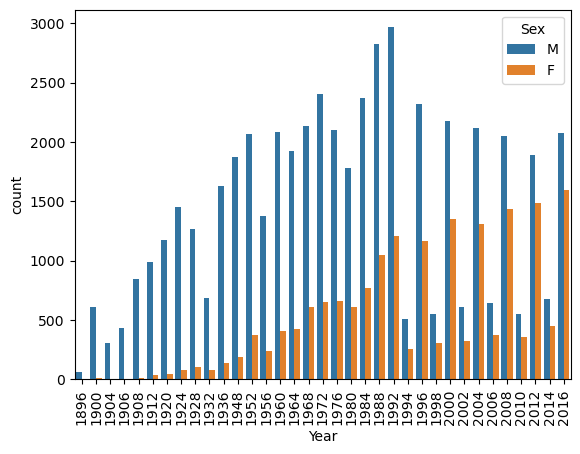

In [ ]:
sns.countplot(olympic_df, x="Year", hue='Sex')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
medals_by_year_sex = olympic_df.groupby(['Year', 'Sex']).size().unstack(fill_value=0).reset_index()

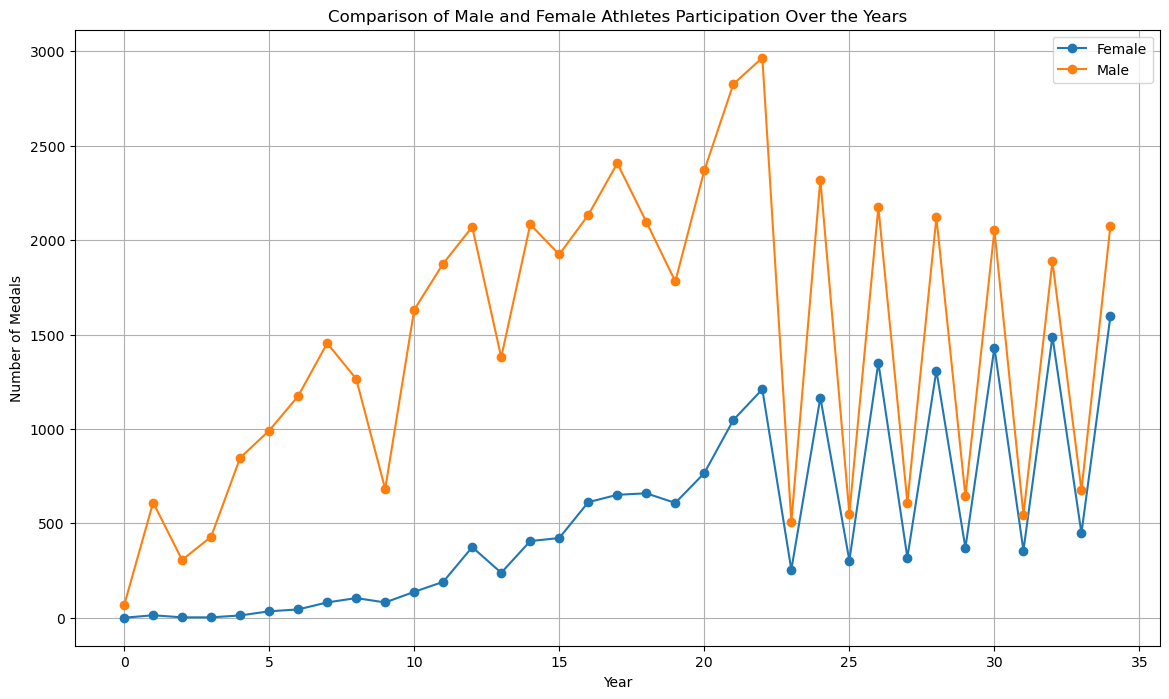

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(medals_by_year_sex.index.values, medals_by_year_sex['F'].values, marker='o', label='Female')
plt.plot(medals_by_year_sex.index.values, medals_by_year_sex['M'].values, marker='o', label='Male')

plt.title('Comparison of Male and Female Athletes Participation Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.legend()
plt.grid(True)
plt.show()

### Distribution of the medals over gender and age

We see that in total men got more medals then women, is due to high quantity of men participation to the olympic games. 

In [ ]:
no_medal_mask= olympic_df[olympic_df['Medal']!='no-medal']

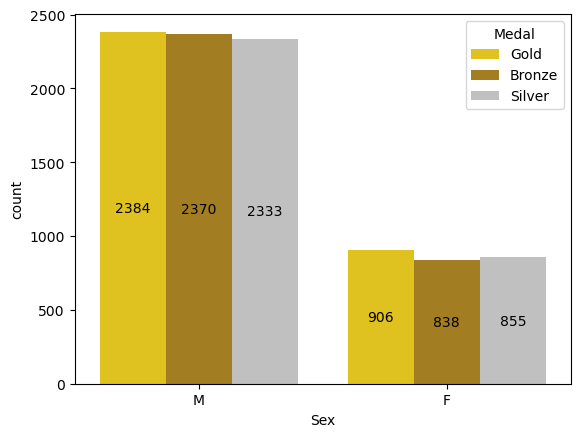

In [ ]:
colors = ['gold', 'darkgoldenrod', 'silver']

ax = sns.countplot(no_medal_mask, x="Sex", hue='Medal', palette=colors)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, fontsize=10)

plt.show()

### Same visualizations for after 1980

In [ ]:
no_medal_mask = olympic_df[olympic_df['Medal']!='no-medal']
df_after_1980 = no_medal_mask[no_medal_mask['Year']>1980].copy()

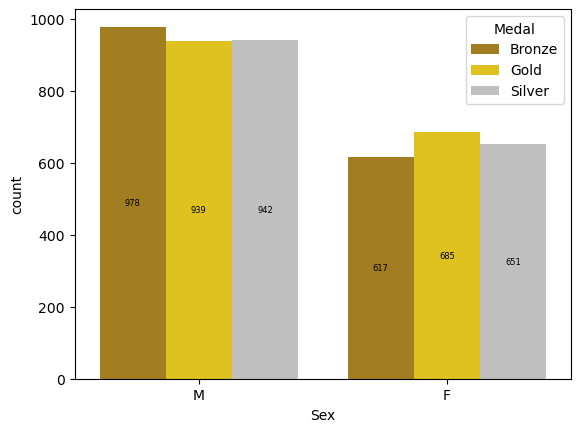

In [ ]:
colors = [ 'darkgoldenrod', 'gold','silver']
ax = sns.countplot(df_after_1980, x="Sex", hue='Medal', palette=colors)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, fontsize=6)

plt.show()

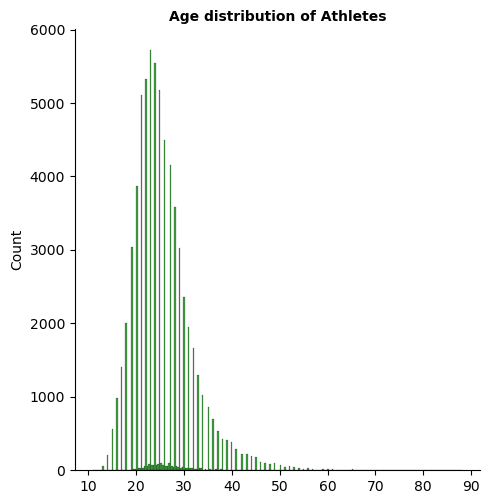

In [287]:
x = sns.displot(olympic_df['Age'].values, color='green')
plt.title('Age distribution of Athletes', fontsize=10, fontweight='bold')
plt.show()

In [ ]:
# sns.countplot(olympic_df, x="Age", hue='Medal')
# plt.xticks(rotation=90)
# plt.show()

### Total medals gained by each country and visualization of top 10 team with most medals

From the table, we can see that the United States leads with the highest number of total medals (1460) and the highest proportion of medals won (0.57). This indicates a high success rate for American athletes. Other countries like France and Italy have the same total number of medals (571), but Italy has a slightly higher proportion (0.31) compared to France (0.25), suggesting that Italy had a more efficient medal-winning performance relative to the number of athletes.

Great Britain, Germany, Australia, Sweden, and Canada also have notable performances, with varying proportions of medals won. Germany, for instance, has a proportion of 0.43, which is relatively high compared to its total number of athletes (916). 

In [212]:
medal_count = olympic_df.groupby(['NOC','Medal']).size().unstack(fill_value=0) #.reset_index()
medal_count['Total'] = medal_count[['Gold', 'Silver', 'Bronze']].sum(axis=1)
# medal_count

ten_team_with_most_medals = medal_count.sort_values(by=['Total'], ascending=False).head(10)
ten_team_with_most_medals

Medal,Bronze,Gold,Silver,no-medal,Total
NOC,,,,,
USA,366,747,448,3572,1561
FRA,257,184,216,4169,657
ITA,194,217,193,3559,604
GBR,186,210,207,2888,603
URS,149,216,150,686,515
GER,144,148,142,1607,434
AUS,151,98,124,1897,373
SWE,145,84,136,1761,365
CAN,127,119,114,2302,360


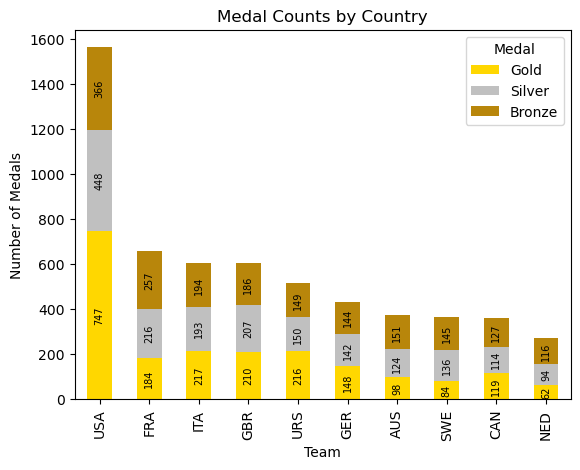

In [39]:
colors = ['gold', 'silver', 'darkgoldenrod']

ax = ten_team_with_most_medals.set_index('NOC')[['Gold', 'Silver', 'Bronze']].plot(kind='bar', stacked=True, color=colors)

ax.set_title('Medal Counts by Country')
ax.set_xlabel('Team')
ax.set_ylabel('Number of Medals')

# number of medals for each type on labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=90, fontsize=7)

plt.show()

In [214]:
team_medal_count = olympic_df.groupby(['NOC', 'Medal']).size()
team_medal_count
team_athlete_count = olympic_df.groupby('NOC')['ID'].nunique().sort_values(ascending=False).head(10)
team_athlete_count = team_athlete_count.reset_index()

team_athlete_count.columns = ['NOC', 'Total Athletes']

ten_team_with_most_medals = ten_team_with_most_medals.merge(team_athlete_count, on="NOC")

ten_team_with_most_medals['Proportion'] = ten_team_with_most_medals['Total']/ten_team_with_most_medals['Total Athletes']
ten_team_with_most_medals

,NOC,Bronze,Gold,Silver,no-medal,Total,ID,Total Athletes,Proportion
0,USA,366,747,448,3572,1561,2704,2704,0.58
1,FRA,257,184,216,4169,657,2401,2401,0.27
2,ITA,194,217,193,3559,604,1930,1930,0.31
3,GBR,186,210,207,2888,603,1865,1865,0.32
4,GER,144,148,142,1607,434,982,982,0.44
5,AUS,151,98,124,1897,373,1152,1152,0.32
6,SWE,145,84,136,1761,365,1000,1000,0.36
7,CAN,127,119,114,2302,360,1341,1341,0.27


### Visualization of 10 athlete with most medals

In the table is displayed the success percentage of the top 10 athletes who have won the most medals. The success percentage is calculated as the proportion of medals won to the total number of games participated in, without differentiating between the types of medals (gold, silver, or bronze). Interestingly, some athletes, such as Natalie Anne Coughlin and Raymond Clarence "Ray" Ewry, have achieved a 100% success rate, meaning they won a medal in every event they participated in, even though they have fewer total medals compared to other athletes in the list.

In [41]:
athlete_medal_count = olympic_df.groupby(['ID','Medal']).size().unstack(fill_value=0)
athlete_medal_count['Total'] = athlete_medal_count[['Gold', 'Silver', 'Bronze']].sum(axis=1)
athlete_medal_count = athlete_medal_count.reset_index()
athlete_medal_count = athlete_medal_count[['ID','Gold', 'Silver', 'Bronze', 'Total']]
athlete_medal_count.columns.name = None

athlete_name = olympic_df[['ID', 'Name']].drop_duplicates()
athlete_medal_count = athlete_medal_count.merge(athlete_name, on='ID')
ten_athlete_with_most_medals = athlete_medal_count.sort_values(by='Total', ascending=False).head(10)

In [42]:
ten_athlete_with_most_medals

,ID,Gold,Silver,Bronze,Total,Name
4197,4198,7,5,3,15,Nikolay Yefimovich Andrianov
11950,11951,8,4,1,13,Ole Einar Bjrndalen
23425,23426,3,4,5,12,Natalie Anne Coughlin (-Hall)
35549,35550,8,4,0,12,Birgit Fischer-Schmidt
21401,21402,7,3,1,11,Viktor Ivanovych Chukarin
11641,11642,8,2,1,11,"Matthew Nicholas ""Matt"" Biondi"
18825,18826,7,4,0,11,Vra slavsk (-Odloilov)
5699,5700,5,2,3,10,Polina Hryhorivna Astakhova
33556,33557,10,0,0,10,"Raymond Clarence ""Ray"" Ewry"
9746,9747,2,3,5,10,Stefania Belmondo


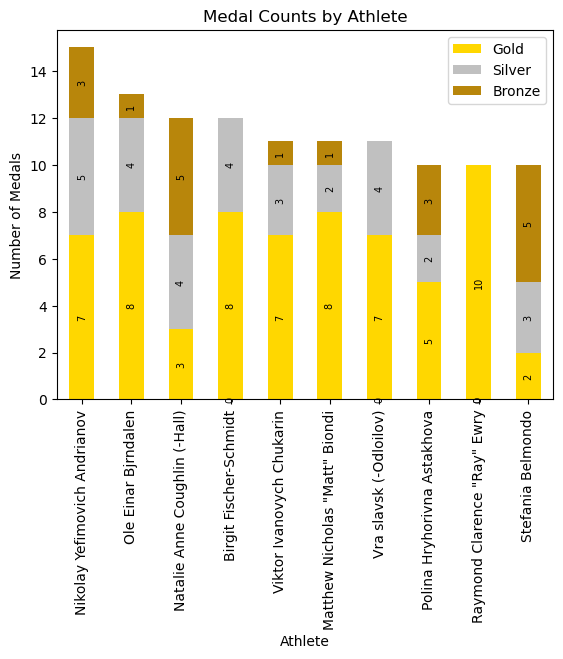

In [43]:
colors = ['gold', 'silver', 'darkgoldenrod']

ax = ten_athlete_with_most_medals.set_index('Name')[['Gold', 'Silver', 'Bronze']].plot(kind='bar', stacked=True, color=colors)

ax.set_title('Medal Counts by Athlete')
ax.set_xlabel('Athlete')
ax.set_ylabel('Number of Medals')

# number of medals for each type on labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=90, fontsize=7)

plt.show()

In [44]:
athlete_participation_count = olympic_df['ID'].value_counts()
ten_athlete_with_most_medals = ten_athlete_with_most_medals.merge(athlete_participation_count ,on='ID')

ten_athlete_with_most_medals.rename(columns={'count':'Total Participation'}, inplace=True)

ten_athlete_with_most_medals['athlete_success_percentage'] = (ten_athlete_with_most_medals['Total']/ten_athlete_with_most_medals['Total Participation'])*100
ten_athlete_with_most_medals

,ID,Gold,Silver,Bronze,Total,Name,Total Participation,athlete_success_percentage
0,4198,7,5,3,15,Nikolay Yefimovich Andrianov,24,62.50
1,11951,8,4,1,13,Ole Einar Bjrndalen,27,48.15
2,23426,3,4,5,12,Natalie Anne Coughlin (-Hall),12,100.00
3,35550,8,4,0,12,Birgit Fischer-Schmidt,13,92.31
4,21402,7,3,1,11,Viktor Ivanovych Chukarin,16,68.75
5,11642,8,2,1,11,"Matthew Nicholas ""Matt"" Biondi",12,91.67
6,18826,7,4,0,11,Vra slavsk (-Odloilov),18,61.11
7,5700,5,2,3,10,Polina Hryhorivna Astakhova,19,52.63
8,33557,10,0,0,10,"Raymond Clarence ""Ray"" Ewry",10,100.00
9,9747,2,3,5,10,Stefania Belmondo,22,45.45


### 10 SPORTS WITH MOST PARTCIPANT NUMBER AND WHICH COUNTRY IS GOOD IN WHICH SPORT

In [45]:
sport_athlete_count = olympic_df.groupby('Sport')['ID'].nunique().sort_values(ascending=False).head(10)
sport_athlete_count = sport_athlete_count.reset_index()
sport_athlete_count = sport_athlete_count.rename(columns={'ID' : 'Total Athletes'})
print(sport_athlete_count)

       Sport  Total Athletes
0  Athletics            6045
1   Swimming            2273
2     Rowing            1962
3   Football            1800
4    Cycling            1520
5     Boxing            1456
6   Shooting            1331
7    Sailing            1297
8  Wrestling            1293
9    Fencing            1214


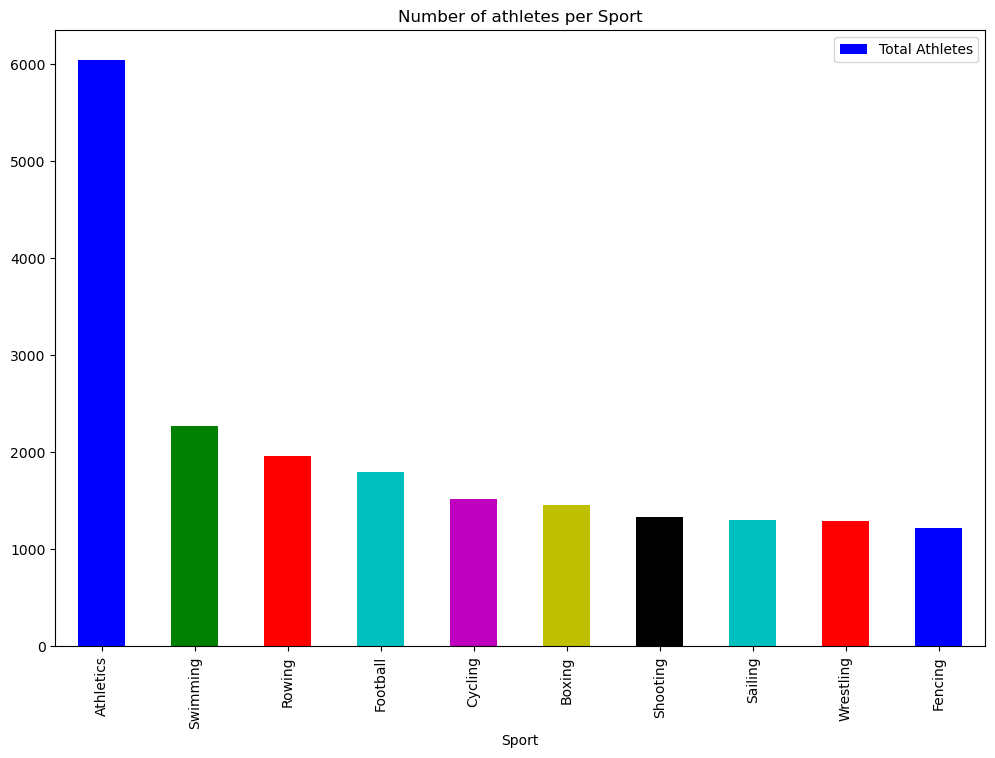

In [46]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'c', 'r', 'b']
sport_athlete_count.plot(kind='bar', x='Sport', y='Total Athletes', figsize=(12,8), title='Number of athletes per Sport', color=colors[:len(sport_athlete_count)])
plt.xticks(rotation = 90)
plt.show()

In [47]:
df_olympic_with_ten_sports = sport_athlete_count.merge(olympic_df, on='Sport')

In [48]:
df_olympic_with_ten_sports['Sport'].unique()

array(['Athletics', 'Swimming', 'Rowing', 'Football', 'Cycling', 'Boxing',
       'Shooting', 'Sailing', 'Wrestling', 'Fencing'], dtype=object)

Most sucessful teams for each sport

In [49]:
# medal_count = df_olympic_with_ten_sports.groupby(['Sport', 'Team','Medal']).size().unstack(fill_value=0).reset_index()
# medal_count['Total'] = medal_count[['Gold', 'Silver', 'Bronze']].sum(axis=1)
# # medal_count

# medal_count = medal_count.sort_values(by=['Sport', 'Total'], ascending=[True, False]).head(10)

# team_with_most_medals = medal_count.groupby('Sport').first().reset_index()

# team_with_most_medals


### Check if there are shared medals 

In [50]:
# column_to_compare = ['Sex', 'Year', 'Season', 'Event', 'Medal']
# mask = olympic_df[column_to_compare].duplicated(keep='first')
# result_df = olympic_df[mask]

# grouped = result_df.groupby(column_to_compare).filter(lambda x: len(x) > 1)

# grouped[(grouped['Games']=='1920 Summer') & (grouped['Medal']=='Gold')].sort_values(by='Event')


### Winter Games dataframe and Summer Games dataframe

In [215]:
winter_df = olympic_df[olympic_df['Season'] == 'Winter']
summer_df = olympic_df[olympic_df['Season'] == 'Summer']

### CORRELATIN MATRIX

<AxesSubplot:>

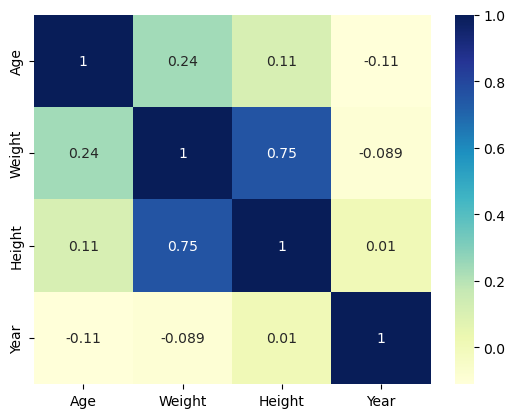

In [51]:
corr_df = olympic_df[['Age', 'Weight', 'Height', 'Year']]
corr_df.corr()
sns.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1300x1700 with 0 Axes>

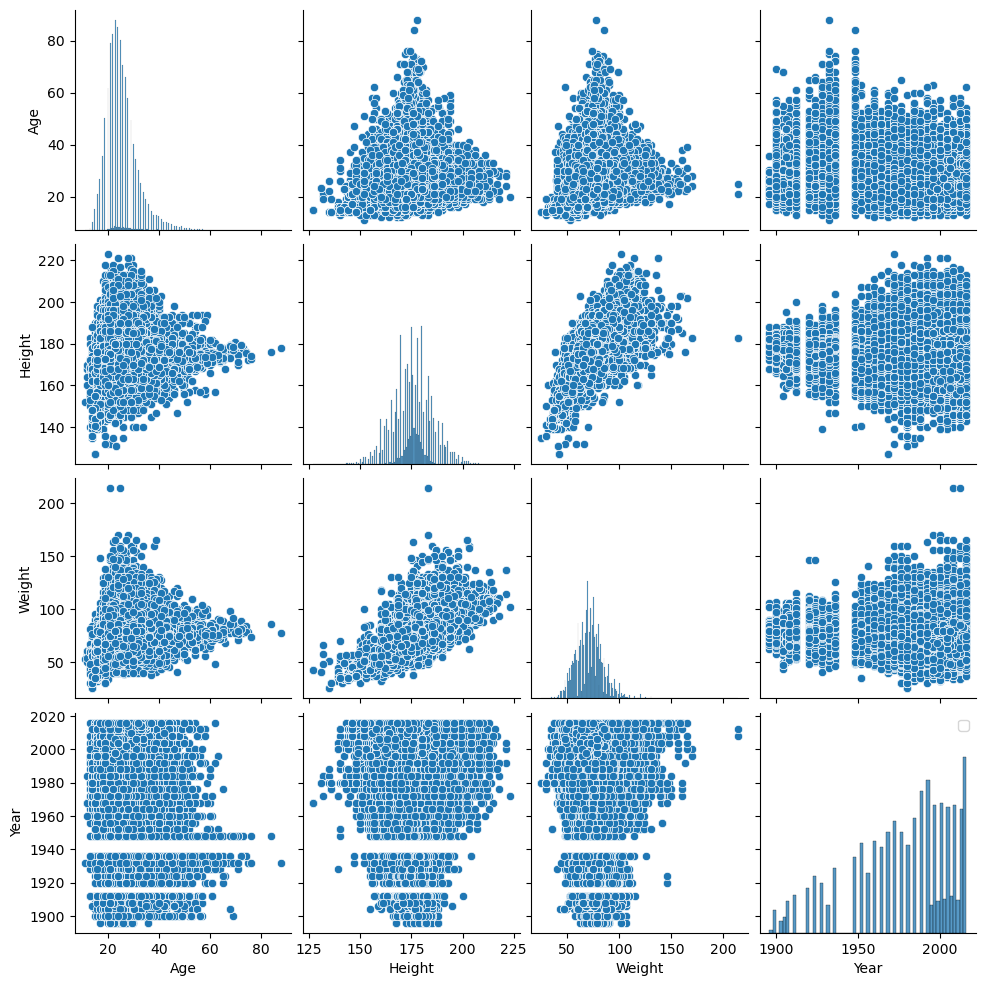

In [52]:
plt.figure(figsize=(13,17))
sns.pairplot(data=olympic_df.drop(columns='ID'))
plt.legend()
plt.show()

**NUMERICAL ENCODING**

COLUMNS CAN BE TRANSFORM:
- SEX: M/F -> 0/1
- MEDAL: NaN, Bronze, Silver, Gold -> 0, 1, 2, 3

I can use two methods to encode the labels:
1. LabelEncoder from sklearn library
2. Doing it by hand

As I have just few labels to encode, I prefer to use second method because LabelEncoder assign numbers starting from 0 and so on and in my case is not preferable a generic assignment because of the different priorty/importance of the medal types. Instead for Sex encoding it can be used LabelEncoding but for code clearity I will use one method for all my features that I want to encode.

In [53]:
replace_sex={
    'M':0,
    "F":1
}
olympic_df['Sex'] = olympic_df['Sex'].replace(replace_sex)


replace_medal={
    "non-medal":0,
    "Bronze":1,
    "Silver":2,
    "Gold":3
}
olympic_df['Medal'] = olympic_df['Medal'].replace(replace_medal)

pd.set_option("future.no_silent_downcasting", True)

In [54]:
olympic_df.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

In [55]:
# label_encoder = preprocessing.LabelEncoder() 
# olympic_df['Sex']= label_encoder.fit_transform(olympic_df['Sex']) 

**HISTOGRAM**

From the histogram below we can see that:

- Men participated more than women to olympic games
- The majority of the athletes age is between ~18 and ~25
- Most athletes are between 160cm and 190cm 
- Most athletes weigh between 50 and 100 and the peak is  around 175
- Participation to the olympic games has increased over time. 
- Due to high participation most of athletes didn't win medals 

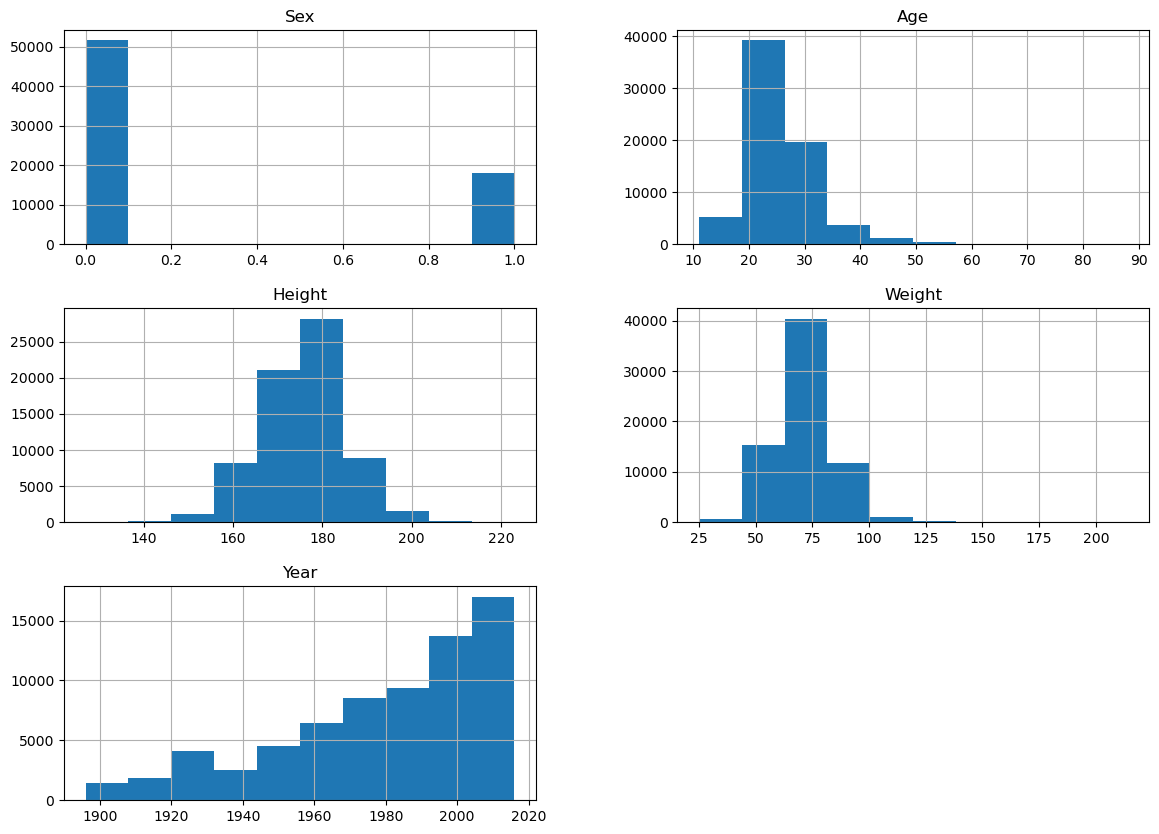

In [56]:
olympic_df.drop(columns='ID').hist(figsize=(14,10))
plt.show()

<AxesSubplot:>

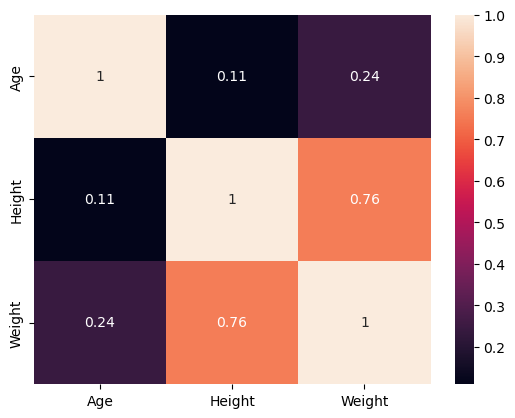

In [288]:
corr_df = olympic_df.drop(columns=['ID', 'Year']).select_dtypes(include=['number'])
# corr_df.corr()
sns.heatmap(corr_df.corr(), annot=True)

# MODEL 

# CONCLUSION